In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_Original = '/content/drive/MyDrive/TFM/Google_Colab/TFM_dataset_imagenes/Datasets/Original'
ruta_Normalizado = '/content/drive/MyDrive/TFM/Google_Colab/TFM_dataset_imagenes/Datasets/Normalizado'


# Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.utils import shuffle
from keras.models import load_model

import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Def

## Convertir a 3D

In [ ]:
def mean(data, no_elements):  # Toma dos argumentos: un conjunto de datos y un número de elementos.
    X = np.zeros((data.shape[0], data.shape[1]))  # Creamos una matriz de ceros con la misma forma que los datos de entrada.
    for i in range(data.shape[1] - no_elements + 1):  # En las últimas filas no se calcula la media, quedaran no_elements -1 filas de ceros al final
        X[:, i] = np.mean(data[:, i:i + no_elements], axis=1)  # asignamos a la columna i-ésima de X la media de la submatriz de los datos que va desde la columna i hasta la columna i + no_elements, a lo largo del eje 1 (columnas).
    return X.astype(np.float16)  # Finalmente, convertimos los valores en la matriz X a float16 para ahorrar memoria y la retornamos.

def median(data, no_elements):
    X = np.zeros((data.shape[0], data.shape[1]))
    for i in range(data.shape[1] - no_elements + 1):
        X[:, i] = np.median(data[:, i:i + no_elements], axis=1)
    return X.astype(np.float16)

def sig_image(data, size):  # Toma dos argumentos: un conjunto de datos y un tamaño.
    X = np.zeros((data.shape[0], size, size))  # Creamos una matriz de ceros con la forma especificada: número de filas en los datos y tamaño dado al cuadrado.
    for i in range(data.shape[0]):  # Para cada índice desde 0 hasta el número de filas en los datos,
        X[i] = (data[i, :].reshape(size, size))  # asignamos a la i-ésima entrada de X los datos en la fila i, reorganizados como una matriz de tamaño size x size.
    return X.astype(np.float16)  # Finalmente, convertimos los valores en la matriz X a float16 para ahorrar memoria y la retornamos.

def convertir_a_imagenes(dataset):
    channel_mean = (mean(dataset, 10)).astype(np.float16)
    # Esto calculará la media en ventanas de tamaño 10 a lo largo de cada columna en 'x'.

    x_mean = sig_image(channel_mean, 40)
    # Esta función remodelará cada fila en 'channel_mean' en una imagen de 40x40.

    channel_median = (median(dataset, 10)).astype(np.float16)
    # Esto calculará la mediana en ventanas de tamaño 10 a lo largo de cada columna en 'x'.

    x_md = sig_image(dataset, 40)
    # Esta función remodelará cada fila en 'x' en una imagen de 40x40.

    x_n=sig_image(dataset,40)

    # np.stack() en Numpy se utiliza para unir un secuencia de arrays a lo largo de un nuevo eje.
    X=np.stack((x_n,x_mean,x_md),axis=1).astype(np.float16)

    # En Keras, los canales van al final
    X = X.transpose(0, 2, 3, 1)

    return X


## Entrenamiento + graficar

In [ ]:
def entrenamiento_grafica(x, y, x_test, y_test, n_test, patience):

  epochs = 200
  metrica_parar = 'val_accuracy'

  x_train, x_train_val, y_train, y_train_val = train_test_split(x, y, test_size=0.2, random_state=20)

  x_test_shuffle, y_test_shuffle = shuffle(x_test, y_test, random_state=42)
  x_test = x_test_shuffle[:n_test]
  y_test = y_test_shuffle[:n_test]


  #Callbacks
  patience = patience

  # EarlyStop si durante 10 epoch no se consigue ninguna mejora en accuracy
  early_stopping = EarlyStopping(monitor=metrica_parar, patience=patience)

  #Imprimir mensaje indicando que no se han conseguido mejoras durante 10 epoch.
  class ImprimirMensajeCallback(Callback):
      def on_train_begin(self, logs=None):
          self.stopped_epoch = 0

      def on_epoch_end(self, epoch, logs=None):
          if self.model.stop_training:
             self.stopped_epoch = epoch
             print(f"El entrenamiento ha sido detenido en el epoch {self.stopped_epoch + 1}. Loss no ha mejorado durante {patience} epoch.")


  # Creación del modelo
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=(40, 40, 3)))
  model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
  model.add(Conv2D(64, kernel_size=(4, 4), strides=(1, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  # Compilación del modelo
  model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  mi_callback = ImprimirMensajeCallback()

  # ModelCheckpoint para guardar el mejor modelo
  checkpoint = ModelCheckpoint(
      'modelos/mejor_modelo.h5',  # Ruta relativa al archivo
      monitor=metrica_parar,
      save_best_only=True,
      mode='max',
      verbose=0
  )

  # Entrenamiento del modelo
  history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, verbose=1, validation_data=(x_train_val, y_train_val), callbacks=[early_stopping, mi_callback, checkpoint])

  epoch_donde_se_detuvo = mi_callback.stopped_epoch

  # Crear una gráfica con los datos del DataFrame
  pd.DataFrame(history.history).plot(
    figsize=(10,5),   # Tamaño de la gráfica
    xlim=[0,epoch_donde_se_detuvo],     # Límites del eje X
    ylim=[0,1.5],      # Límites del eje Y
    grid=True,       # Mostrar cuadrícula en la gráfica
    xlabel='Epoch',  # Etiqueta del eje X
    style=['r--','r-']  # Estilo de línea de cada columna
  )
  # Mostrar la gráfica
  ####################
  plt.show()

  # print('********************')
  # acc = history.history['accuracy']
  # ult_acc = acc[-patience-1:]
  # print('Train accuracy: ', ult_acc)

  # loss = history.history['loss']
  # ult_loss = loss[-patience-1:]
  # print('Train loss: ', ult_loss)

  # Test
  ######

  # Cargar el mejor modelo guardado
  mejor_modelo = load_model('modelos/mejor_modelo.h5')

  print('*********TEST**********')
  print(f'Nº de muestras para el test: {x_test.shape}')
  test_loss, test_acc = mejor_modelo.evaluate(x_test, y_test, verbose=0)
  print('Resultados del test:')
  print('\nTest accuracy:', test_acc)
  print('Test loss:', test_loss)

  # Obtener las predicciones del modelo en el conjunto de prueba
  y_pred = model.predict(x_test)
  y_pred_labels = np.argmax(y_pred, axis=1)  # Obtener las etiquetas predichas

  # Calcular la matriz de confusión
  conf_matrix = confusion_matrix(y_test, y_pred_labels)

  # Crear una figura para la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title('Matriz de Confusión')
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Real')
  plt.show()

  # Calcular los porcentajes de acierto por etiqueta
  row_sums = conf_matrix.sum(axis=1, keepdims=True)
  conf_matrix_percent = conf_matrix / row_sums

  # Crear una figura para la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False)
  plt.title('Matriz de Confusión (Porcentaje de Acierto)')
  plt.xlabel('Etiqueta Predicha')
  plt.ylabel('Etiqueta Real')
  plt.show()

## Entrenamiento

In [ ]:
# Train
def entrenamiento(x_train, y_train, x_test, y_test, n_test, patience):
  print(f'x_train = {x_train.shape}')
  x_train_3D = convertir_a_imagenes(x_train)
  print(f'x_train_3D matriz = {x_train_3D.shape}')

  # Test
  print(f'x_test = {x_test.shape}')
  x_test_3D = convertir_a_imagenes(x_test)
  print(f'x_test_3D matriz = {x_test_3D.shape}')

  # Entrenamiento
  ###############
  entrenamiento_grafica(x_train_3D, y_train, x_test_3D, y_test, n_test, patience)

# Original

## Original

x_train = (2240, 1600)
x_train_3D matriz = (2240, 40, 40, 3)
x_test = (560, 1600)
x_test_3D matriz = (560, 40, 40, 3)
Epoch 1/200
 6/14 [===========>..................] - ETA: 0s - loss: 2.1071 - accuracy: 0.1823 

14/14 [==============================] - 3s 37ms/step - loss: 1.9266 - accuracy: 0.2271 - val_loss: 1.6842 - val_accuracy: 0.3013
Epoch 2/200
14/14 [==============================] - 0s 18ms/step - loss: 1.4855 - accuracy: 0.4263 - val_loss: 1.3263 - val_accuracy: 0.4799
Epoch 3/200
14/14 [==============================] - 0s 18ms/step - loss: 1.1737 - accuracy: 0.5608 - val_loss: 0.9749 - val_accuracy: 0.6451
Epoch 4/200
14/14 [==============================] - 0s 15ms/step - loss: 0.8617 - accuracy: 0.7098 - val_loss: 0.7549 - val_accuracy: 0.7768
Epoch 5/200
14/14 [==============================] - 0s 15ms/step - loss: 0.5971 - accuracy: 0.8304 - val_loss: 0.5547 - val_accuracy: 0.7879
Epoch 6/200
14/14 [==============================] - 0s 14ms/step - loss: 0.4720 - accuracy: 0.8359 - val_loss: 0.4068 - val_accuracy: 0.8728
Epoch 7/200
14/14 [==============================] - 0s 11ms/step - loss: 0.4259 - accuracy: 0.8482 - val_loss: 0.4897 - val_accuracy: 0.7924
Epoch 8/200
14/14 

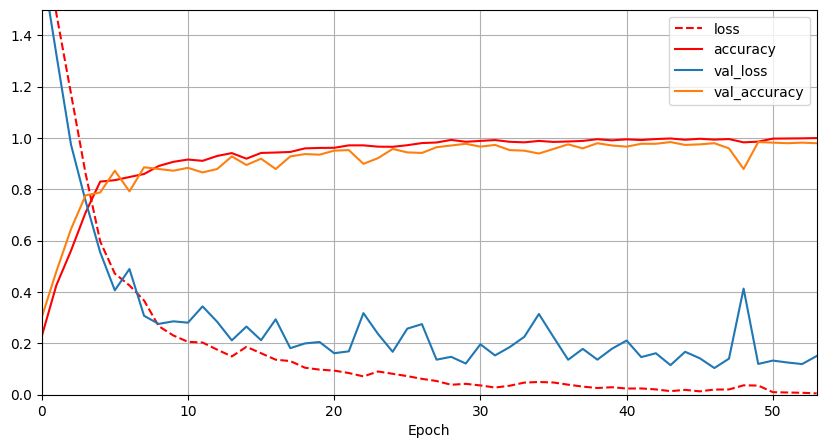

*********TEST**********
Nº de muestras para el test: (560, 40, 40, 3)
Resultados del test:

Test accuracy: 0.9767857193946838
Test loss: 0.060652412474155426
18/18 [==============================] - 0s 2ms/step


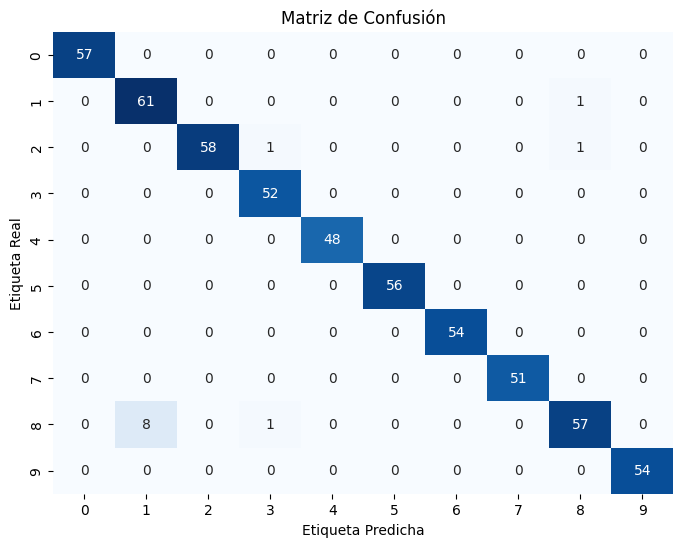

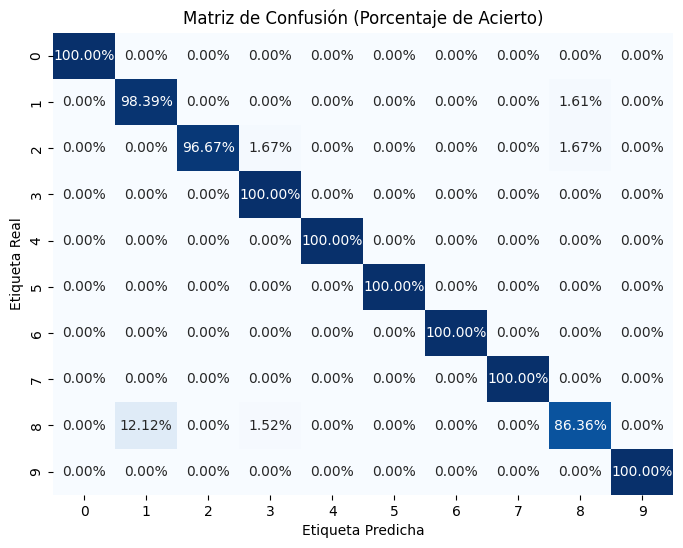

In [ ]:
x_train =np.load(f'{ruta_Original}/x_train_original.npy')
y_train =np.load(f'{ruta_Original}/y_train_original.npy')

x_test = np.load(f'{ruta_Original}/x_test_original.npy')
y_test = np.load(f'{ruta_Original}/y_test_original.npy')

entrenamiento(x_train, y_train, x_test, y_test, 560, 10)

## Original desbalanceado

x_train = (380, 1600)
x_train_3D matriz = (380, 40, 40, 3)
x_test = (560, 1600)
x_test_3D matriz = (560, 40, 40, 3)
Epoch 1/200
3/3 [==============================] - 3s 292ms/step - loss: 2.4677 - accuracy: 0.2533 - val_loss: 2.1930 - val_accuracy: 0.0789
Epoch 2/200
3/3 [==============================] - 0s 54ms/step - loss: 2.1817 - accuracy: 0.1513 - val_loss: 2.0740 - val_accuracy: 0.5921
Epoch 3/200
3/3 [==============================] - 0s 54ms/step - loss: 2.0667 - accuracy: 0.6612 - val_loss: 1.9153 - val_accuracy: 0.6184
Epoch 4/200
3/3 [==============================] - 0s 24ms/step - loss: 1.8868 - accuracy: 0.6678 - val_loss: 1.7826 - val_accuracy: 0.5921
Epoch 5/200
3/3 [==============================] - 0s 32ms/step - loss: 1.5921 - accuracy: 0.6776 - val_loss: 1.6128 - val_accuracy: 0.5921
Epoch 6/200
3/3 [==============================] - 0s 43ms/step - loss: 1.2394 - accuracy: 0.7007 - val_loss: 1.4981 - val_accuracy: 0.6316
Epoch 7/200
3/3 [==========================

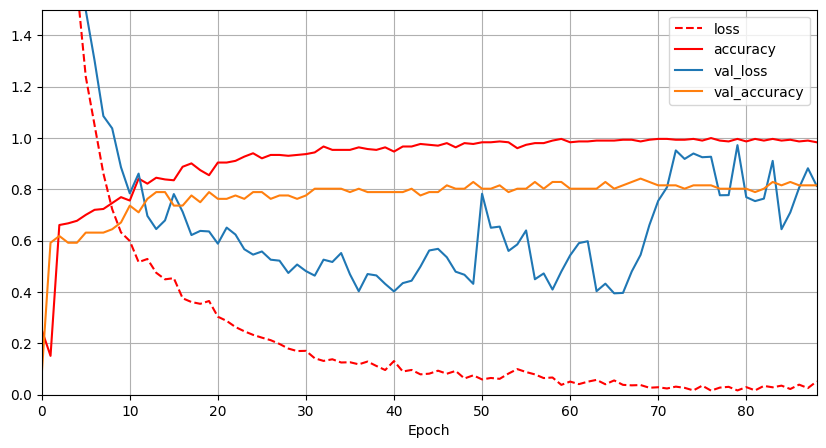

*********TEST**********
Nº de muestras para el test: (76, 40, 40, 3)
Resultados del test:

Test accuracy: 0.75
Test loss: 0.73112553358078
3/3 [==============================] - 0s 3ms/step


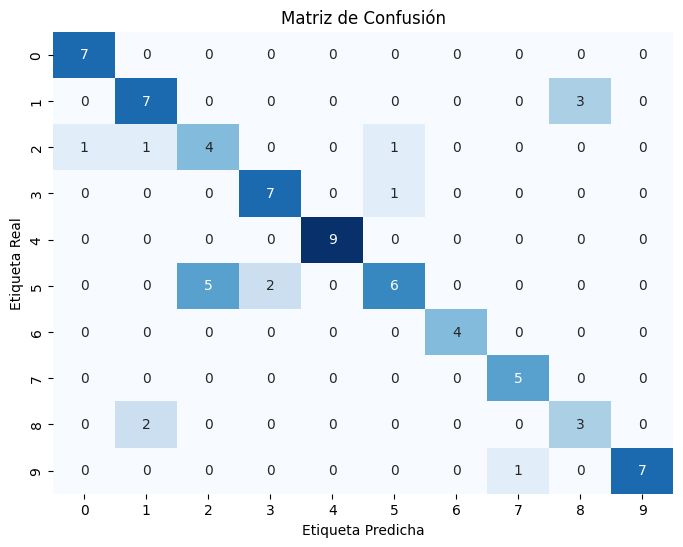

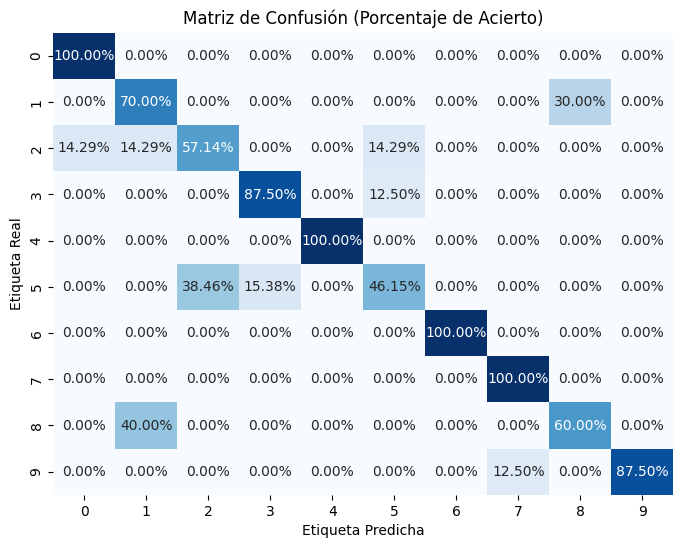

In [ ]:
x_train_desbalanceado =np.load(f'{ruta_Original}/x_train_original_desbalanceado.npy')
y_train_desbalanceado =np.load(f'{ruta_Original}/y_train_original_desbalanceado.npy')

x_test = np.load(f'{ruta_Original}/x_test_original.npy')
y_test = np.load(f'{ruta_Original}/y_test_original.npy')

entrenamiento(x_train_desbalanceado, y_train_desbalanceado, x_test,y_test, 100, 10)

## Original DCGAN 5

x_train = (425, 1600)
x_train_3D matriz = (425, 40, 40, 3)
x_test = (560, 1600)
x_test_3D matriz = (560, 40, 40, 3)
Epoch 1/200
3/3 [==============================] - 2s 247ms/step - loss: 2.2805 - accuracy: 0.1471 - val_loss: 2.1893 - val_accuracy: 0.4706
Epoch 2/200
3/3 [==============================] - 0s 38ms/step - loss: 2.1468 - accuracy: 0.4735 - val_loss: 2.1302 - val_accuracy: 0.5412
Epoch 3/200
3/3 [==============================] - 0s 23ms/step - loss: 2.0007 - accuracy: 0.5853 - val_loss: 1.9550 - val_accuracy: 0.5294
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 1.7891 - accuracy: 0.5794 - val_loss: 1.7733 - val_accuracy: 0.5294
Epoch 5/200
3/3 [==============================] - 0s 23ms/step - loss: 1.5214 - accuracy: 0.5824 - val_loss: 1.4832 - val_accuracy: 0.5412
Epoch 6/200
3/3 [==============================] - 0s 38ms/step - loss: 1.2238 - accuracy: 0.6176 - val_loss: 1.2683 - val_accuracy: 0.6235
Epoch 7/200
3/3 [==========================

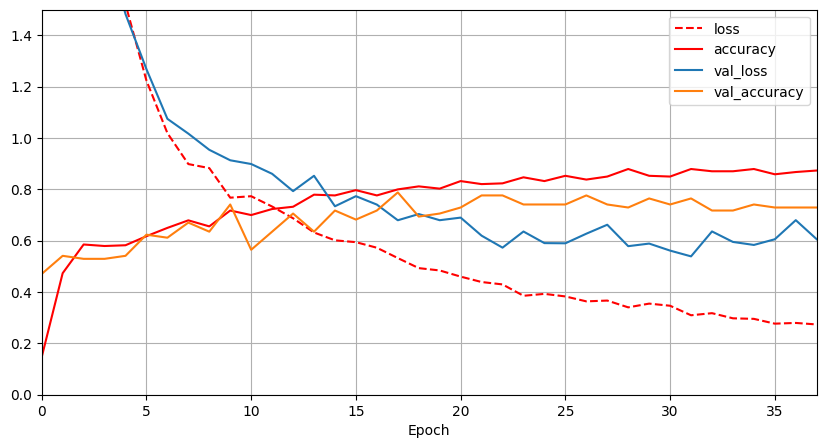

*********TEST**********
Nº de muestras para el test: (85, 40, 40, 3)
Resultados del test:

Test accuracy: 0.4117647111415863
Test loss: 2.906184196472168
3/3 [==============================] - 0s 4ms/step


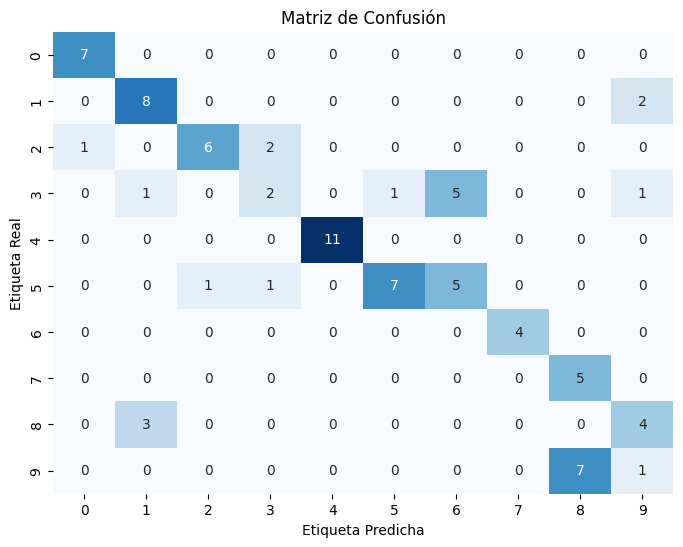

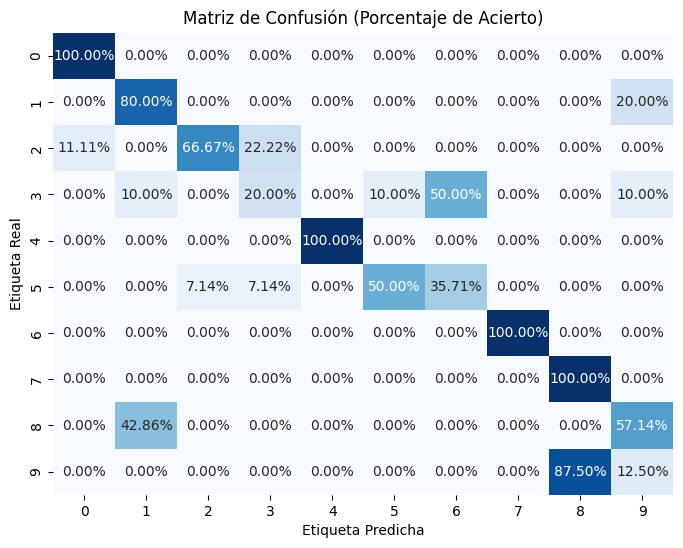

In [ ]:
x_train_desbalanceado =np.load(f'{ruta_Original}/x_train_Original_DCGAN_5.npy')
y_train_desbalanceado =np.load(f'{ruta_Original}/y_train_Original_DCGAN_5.npy')

x_test = np.load(f'{ruta_Original}/x_test_original.npy')
y_test = np.load(f'{ruta_Original}/y_test_original.npy')


entrenamiento(x_train_desbalanceado, y_train_desbalanceado, x_test,y_test, 85, 20)

## Original DCGAN 20

x_train = (560, 1600)
x_train_3D matriz = (560, 40, 40, 3)
x_test = (560, 1600)
x_test_3D matriz = (560, 40, 40, 3)
Nº de muestras para el test: (112, 40, 40, 3)
Epoch 1/200
5/5 [==============================] - 2s 111ms/step - loss: 2.3679 - accuracy: 0.0911 - val_loss: 2.3160 - val_accuracy: 0.1250
Epoch 2/200
5/5 [==============================] - 0s 26ms/step - loss: 2.2114 - accuracy: 0.4500 - val_loss: 2.2932 - val_accuracy: 0.0804
Epoch 3/200
5/5 [==============================] - 0s 16ms/step - loss: 2.0627 - accuracy: 0.4607 - val_loss: 2.3672 - val_accuracy: 0.1250
Epoch 4/200
5/5 [==============================] - 0s 16ms/step - loss: 1.8918 - accuracy: 0.4875 - val_loss: 2.2061 - val_accuracy: 0.0804
Epoch 5/200
5/5 [==============================] - 0s 16ms/step - loss: 1.6281 - accuracy: 0.5304 - val_loss: 1.9489 - val_accuracy: 0.2232
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 1.3881 - accuracy: 0.5357 - val_loss: 2.2389 - val_accuracy: 0.25

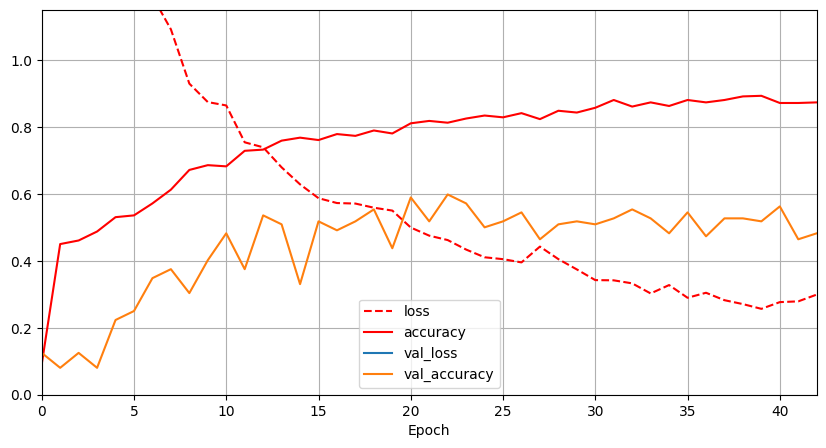

********************
Train accuracy:  [0.8125, 0.824999988079071, 0.8339285850524902, 0.8285714387893677, 0.8410714268684387, 0.8232142925262451, 0.8482142686843872, 0.8428571224212646, 0.8571428656578064, 0.8803571462631226, 0.8607142567634583, 0.8732143044471741, 0.862500011920929, 0.8803571462631226, 0.8732143044471741, 0.8803571462631226, 0.8910714387893677, 0.8928571343421936, 0.8714285492897034, 0.8714285492897034, 0.8732143044471741]
Train loss:  [0.46196892857551575, 0.43358930945396423, 0.41055500507354736, 0.4049205482006073, 0.39524269104003906, 0.44246813654899597, 0.4050118625164032, 0.3742518424987793, 0.34234941005706787, 0.3416774272918701, 0.33261528611183167, 0.30252939462661743, 0.32756417989730835, 0.2895437479019165, 0.30455586314201355, 0.28235647082328796, 0.2707067131996155, 0.25654715299606323, 0.2766019403934479, 0.2788701057434082, 0.2991305887699127]


*******************
Resultados del test:

Test accuracy: 0.4821428656578064
Test loss: 2.390166997909546
4/4 [==============================] - 0s 4ms/step


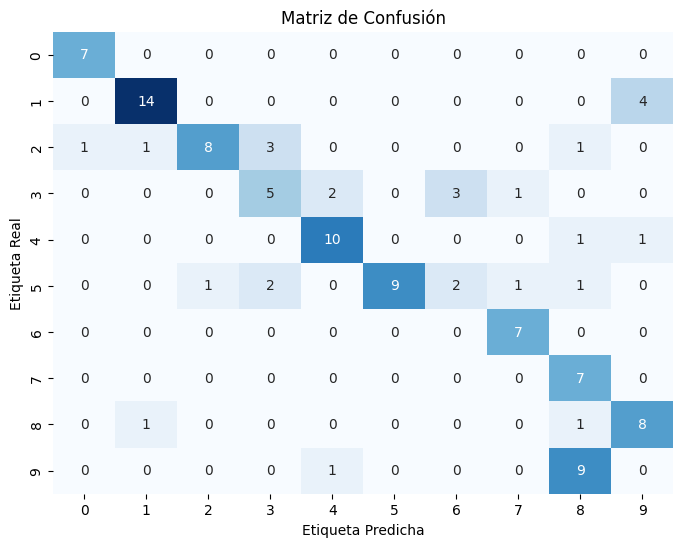

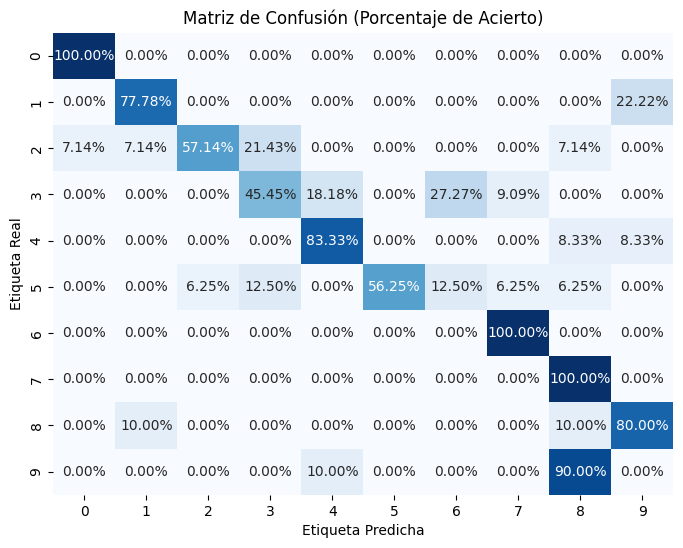

In [ ]:
x_train_desbalanceado =np.load(f'{ruta_Original}/x_train_Original_DCGAN_20.npy')
y_train_desbalanceado =np.load(f'{ruta_Original}/y_train_Original_DCGAN_20.npy')

x_test = np.load(f'{ruta_Original}/x_test_original.npy')
y_test = np.load(f'{ruta_Original}/y_test_original.npy')


entrenamiento(x_train_desbalanceado, y_train_desbalanceado, x_test,y_test, 112, 20)